# Initial analysis in terms of degree distribution, small-world properties and centrality measures 

Degree analysis

In [1]:
import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import time
import collections
import community
import scipy.io
from networkx.algorithms.link_analysis import hits
from itertools import product
import itertools
import powerlaw as pl

#1.Creation of Graph
def createGraph(file):
    G=nx.Graph()

    mat = scipy.io.loadmat(file) #matlab file containing an adjacency matrix for the coactivation 
    #network that includes the weights of each edge and the coordinates of each node in the brain

    content = list(mat.values()) #content[3] weights of the edges; content[4] coordinates
    G = nx.from_numpy_matrix(content[3])

    return G

#2.Degree analysis
#Average Degree
def averageDegree(G):
    E = G.number_of_edges()
    N = G.number_of_nodes()
    av_degree = (2*E)/N
    return av_degree

#Average Weighted Degree:
def averageWeightedDegree(G):
    N = G.number_of_nodes()
    weightedDegree = np.zeros(N)
    #we start by computing the weighted degree for each node (sum of weights of the edges linked to that node        
    for u, v, w in G.edges(data = 'weight'):
        #add weight to both nodes that share the edge
        weightedDegree[u] += w
        weightedDegree[v] += w
    av_weightedDegree = sum(weightedDegree)/N
    return [weightedDegree, av_weightedDegree]

#Degree Distribution   
#obtain plot of histogram, degree distribution and cumulative degree distribution
def degreeDistribution(G):
    #get sequence of the degrees of each node ordered 
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence) #gives a list that as the degree and number of times it repeats
    degree, count = zip(*degreeCount.items()) #to obtain arguments separated 
    
    plt.figure() 
    #plt.bar(degree, count, width=1) #plot histogram
    plt.hist(degree_sequence, bins=19, rwidth=0.4)
    plt.xticks(np.arange(0, 190, 10))
    plt.title("Degree Histrogram")
    plt.ylabel("number of nodes")
    plt.xlabel("k")
    
    N = G.number_of_nodes()
    count = list(count) #convert to list
    #print("Count before norm:", count)
    # normalize count to obtain P(k)
    for i in range(len(count)):
        count[i] = count[i]/N
    
    count_cum = []
    for i in range(len(count)):
        count_cum += [sum(count[0:i+1])] #append each cum_sum to the list

    plt.figure()
    plt.loglog(degree, count_cum, 'o') #plot with log scaling on both axis
    plt.title("Cumulative Degree Distribution with log-log scale")
    plt.ylabel("log₁₀ Pcum(k)")
    plt.xlabel("log₁₀ k")
    
    degrees = G.degree() #get list with pairs (node, degree)
    valuesDeg = [d for n, d in degrees] #get list of degrees of each node
    #print("Degrees:", valuesDeg)

G = createGraph('Coactivation_matrix.mat')

av_degree = averageDegree(G)
print("The Average Degree of the network is: ", av_degree)

weightedDegree, av_w_degree = averageWeightedDegree(G)
print("The Average Weighted Degree of the network is: ", av_w_degree)

degreeDistribution(G)

The Average Degree of the network is:  58.38557993730407
The Average Weighted Degree of the network is:  3.2879135834493365


Computing clustering coefficient and average path length of the coactivation network

In [2]:
#Getting average path length for every connected component
def averagePathLength(G):
    num_connected_components = 0
    path_length_sum = 0
    for g in nx.connected_component_subgraphs(G):
        shortest_path_g = nx.average_shortest_path_length(g)
        path_length_sum += shortest_path_g
        print("Average path lenght of connected component ",num_connected_components, ", having ", g.number_of_nodes(), " nodes: ", shortest_path_g)
        num_connected_components += 1
    print("Number of connected components:", num_connected_components)
    average_path_length = path_length_sum/num_connected_components
    return average_path_length

APL = averagePathLength(G)
print("Total average path length ", APL)

#Finding average clustering coeficient
clustering_coefficient = nx.average_clustering(G) #average clustering coeficient
print("Clustering coefficient: ", clustering_coefficient)

Average path lenght of connected component  0 , having  638  nodes:  2.2148737961545844
Number of connected components: 1
Total average path length  2.2148737961545844
Clustering coefficient:  0.3844533292242755


In [18]:
#Getting clustering and degree for every node
degree_sequence = G.degree()
clustering_sequence = nx.clustering(G)
print(clustering_sequence)

{0: 0.28225806451612906, 1: 0.28923076923076924, 2: 0.38264580369843526, 3: 0.44894894894894893, 4: 0.22413793103448276, 5: 0.4537205081669691, 6: 0.4992163009404389, 7: 0.3860477314450564, 8: 0.21428571428571427, 9: 0.3007518796992481, 10: 0.336827393431167, 11: 0.2548217416715371, 12: 0.42177589852008457, 13: 0.19812925170068027, 14: 0.23673469387755103, 15: 0.24444444444444444, 16: 0.3914240755310779, 17: 0.2066326530612245, 18: 0.4213406292749658, 19: 0.4612640163098879, 20: 0.5882800608828006, 21: 0.24174174174174173, 22: 0.32522474881015334, 23: 0.29324699352451433, 24: 0.25161290322580643, 25: 0.22851153039832284, 26: 0.3473684210526316, 27: 0.43865546218487395, 28: 0.3817663817663818, 29: 0.3935897435897436, 30: 0.4735632183908046, 31: 0.4436701509872242, 32: 0.33978494623655914, 33: 0.5720720720720721, 34: 0.5517241379310345, 35: 0.5902597402597403, 36: 0.3460884353741497, 37: 0.4383869851159571, 38: 0.38001088336658806, 39: 0.4843987823439878, 40: 0.42424242424242425, 41: 0.3

In [3]:
#Creating a random network with the same degree distribution
#to compare with our original network

def null_model_Graph(G):
    degree_sequence = [d for n, d in G.degree()]
    null_model = nx.random_degree_sequence_graph(degree_sequence)
    return null_model
    #print(degree)
#computing clustering coefficient for a random network

G_null = null_model_Graph(G)

E = G.number_of_edges()
N = G.number_of_nodes()
max_E = N*(N-1)*0.5
p = E/max_E #probability of connecting a random node with another

print(p)
#since the probability is quite small, we are going to have a sparse graph 

#computing clustering coefficient for this random graph
random_clustering_coefficient = nx.average_clustering(G_null)
print("Clustering coefficient of random graph: ", random_clustering_coefficient)
#lower than for our case!

#computing APL for this random graph
APL = averagePathLength(G_null)
print("Total average path length of random graph ", APL)
#lower than for our case!

0.09165711136154486
Clustering coefficient of random graph:  0.16004795880381165
Average path lenght of connected component  0 , having  638  nodes:  1.9617919026786022
Number of connected components: 1
Total average path length of random graph  1.9617919026786022


In [4]:
def get_cumm_avg_pathway(G):
    
    cumm_avg_pathway=[]

    for n in G.nodes():
        if (n!=0):
            H = G.subgraph(list(range(0, n)))
            num_connected_components = 0
            path_length_sum = 0
            for g in nx.connected_component_subgraphs(H):
                shortest_path_g = nx.average_shortest_path_length(g)
                path_length_sum += shortest_path_g
                num_connected_components += 1

            tot_avg= path_length_sum/num_connected_components
            cumm_avg_pathway.append(tot_avg)
    return cumm_avg_pathway

cumm_avg_pathway = get_cumm_avg_pathway(G)
print(len(cumm_avg_pathway))
cumm_avg_pathway=[0.0, 1.0, 1.0, 1.3333333333333333, 1.5, 0.75, 2.238095238095238, 2.107142857142857, 1.0535714285714286, 0.9444444444444444, 2.1454545454545455, 2.106060606060606, 2.1025641025641026, 2.032967032967033, 2.0285714285714285, 2.025, 1.9852941176470589, 1.8823529411764706, 1.847953216374269, 1.8842105263157896, 1.9047619047619047, 1.9004329004329004, 1.9565217391304348, 1.923913043478261, 1.9266666666666667, 1.9384615384615385, 2.017094017094017, 1.0085470085470085, 2.2019704433497536, 2.245977011494253, 2.2774193548387096, 2.3044354838709675, 2.3068181818181817, 2.3689839572192515, 2.2705882352941176, 2.3301587301587303, 2.343843843843844, 2.3698435277382646, 2.4021592442645074, 2.428205128205128, 2.4865853658536587, 2.494773519163763, 2.507198228128461, 2.510570824524313, 2.5232323232323233, 2.5603864734299515, 2.5642923219241442, 2.523049645390071, 2.5374149659863945, 2.555918367346939, 2.5309803921568625, 2.539969834087481, 2.584179970972424, 2.5667365478686235, 2.56969696969697, 2.5805194805194804, 2.56140350877193, 2.5335753176043556, 2.537112799532437, 2.531638418079096, 2.526775956284153, 2.527763088313062, 2.5212493599590373, 2.5163690476190474, 2.5177884615384616, 2.5058275058275057, 2.4929895974672096, 2.4969271290605795, 2.4884910485933505, 2.4869565217391303, 2.4780684104627766, 2.473787167449139, 2.468797564687976, 2.4531654942613845, 2.4497297297297296, 2.437894736842105, 2.431989063568011, 2.4305694305694305, 2.428107757221681, 2.4240506329113924, 2.4141975308641976, 2.4182475158084915, 2.4240376138701145, 2.4291451520367184, 2.4198879551820727, 2.4415868673050616, 2.4439989307671746, 2.440700104493208, 2.4402451481103165, 2.432958801498127, 2.437118437118437, 2.4147157190635453, 2.416082281439925, 2.409517272935255, 2.4080627099664054, 2.4017543859649124, 2.3964776632302405, 2.351357037660425, 2.33250876108019, 2.3284848484848486, 2.324158415841584, 2.324014754416618, 2.3232438606510564, 2.318521284540702, 2.3141025641025643, 2.3031446540880505, 2.3073532004937403, 2.294219453097958, 2.2923887189942236, 2.2904086738949125, 2.2986076986076984, 2.2987451737451736, 2.2940897597977243, 2.286135693215339, 2.281769641495042, 2.2818590704647677, 2.2783672266430886, 2.273794002607562, 2.262498219626834, 2.261764705882353, 2.2571625344352615, 2.2503725782414308, 2.244835399173664, 2.2387883556254917, 2.229806451612903, 2.225142857142857, 2.221097362829646, 2.220226377952756, 2.216327519379845, 2.21407274895647, 2.214445096887845, 2.2094610224381217, 2.2083618136249714, 2.2030075187969924, 2.2064123825317856, 2.2092592592592593, 2.210390725633319, 2.2044853485665925, 2.2068605984777396, 2.224563206577595, 2.226646403242148, 2.22455299170912, 2.2248596473948585, 2.2276612276612275, 2.2279693486590038, 2.2243741143127065, 2.2257944273599852, 2.2267880125022983, 2.22972972972973, 2.232751677852349, 2.2343487858719646, 2.2353607528755663, 2.233574131406949, 2.2337662337662336, 2.2193548387096773, 2.2158808933002483, 2.216478850236812, 2.2160767556236394, 2.2119258020858212, 2.210691823899371, 2.2021739130434783, 2.2066559312936125, 2.2084374763311367, 2.211806075115966, 2.2084257206208426, 2.2104417670682732, 2.211817329197028, 2.206943256344454, 2.205409974640744, 2.2021580229725024, 2.2055039559683522, 2.2070583435332516, 2.2074875655330017, 2.1987907780213938, 2.197175697865353, 2.2057142857142855, 2.209488957370313, 2.2087221481622548, 2.2097169041491433, 2.2135940409683426, 2.212277470841007, 2.2095197620059497, 2.2080706179066834, 2.207590876692801, 2.204054054054054, 2.215460621912235, 2.2157437755160716, 2.216236204346342, 2.214398288866374, 2.2161514898357004, 2.21372278864701, 2.212423647469459, 2.211733592400691, 2.2127557288606376, 2.2148559344435634, 2.2206174777603347, 2.22438620118098, 2.221863303081577, 1.1109316515407885, 2.2496482412060304, 2.277860696517413, 2.2707748386778976, 2.267521826074233, 2.2697285810876076, 2.2720707795313246, 2.2778593417002133, 2.281975517095821, 2.27991452991453, 2.2808704453441297, 2.2843928001822738, 2.2908598510494245, 2.2910667978181167, 2.2897953760297636, 2.2947654776008073, 2.300586828950228, 2.3039621016365204, 2.3076890254309608, 2.297298439944193, 2.2970131121444433, 2.2904939809049396, 2.288317564788153, 2.285353226529697, 2.2836423867814, 2.276265214606022, 2.2767460317460317, 2.2771288102261553, 2.274219328681143, 2.2732436818919544, 2.2770244388263237, 2.282741598632998, 2.2760399021268585, 2.2737348858038513, 2.2690543140446944, 2.269249110450827, 2.2685942898708857, 2.264046159394158, 2.262068225702639, 2.2571712229195477, 2.2575858795401005, 2.259449093444909, 2.260511756569848, 2.265731627859127, 2.26799986395946, 2.269378668285772, 2.269120107059217, 2.2698855151816826, 2.2726375037029722, 2.274324147838579, 2.27318953232284, 2.274859437751004, 2.2755059760956176, 2.279010940365522, 2.2789070832549094, 2.280321185148299, 2.283804230353559, 2.2870098039215687, 2.2908864299610894, 2.2934877688293667, 2.2953218999730627, 2.2944757944757943, 2.29596227527262, 2.2970079845573395, 2.2974196731779526, 2.2953681299688906, 2.295340194396798, 2.2968648035182295, 2.297316324519163, 2.2980602604952765, 2.2972313155412527, 2.2978383588049014, 2.297908979089791, 2.298703060560017, 2.298373195432019, 2.2996176572818907, 2.297863304578633, 2.2937285902503293, 2.289645790823, 2.283718151832325, 2.2822516180603905, 2.282130056323605, 2.282282663955262, 2.2815426162893413, 2.28200887151342, 2.281092917931618, 2.2799110452186806, 2.2790577843209423, 2.274993299383543, 2.2730352303523036, 2.2722270280661285, 2.2727836773654695, 2.2725204408105224, 2.2700183589888434, 2.2687596428070504, 2.2687887441666086, 2.267150928167877, 2.266903344021988, 2.264264264264264, 2.2642984656407474, 2.262328567259994, 2.2628316610925308, 2.2646290143964563, 2.2625464786253326, 2.262168600966057, 2.260465520236234, 2.261453839516825, 2.2610736097717776, 2.2634604330331483, 2.265535767164432, 2.2646576724246628, 2.262511744440965, 2.2649102790166995, 2.2672314288069915, 2.268718767920046, 2.268370607028754, 2.2696188454150237, 2.267229254571027, 2.268797668011021, 2.269944249350237, 2.269947359082037, 2.2748824451410656, 2.2775116822429906, 2.2778197016311603, 2.2780031921235313, 2.27989909414058, 2.280246913580247, 2.2832845681925438, 2.286186000262659, 2.285280077571418, 2.2803024686781823, 2.2813852813852815, 2.278330129085416, 2.275834455647363, 2.273363725170954, 2.271618924313535, 2.2687460899097327, 2.26773276474769, 2.2697647308181432, 2.270257931979, 2.26967586531916, 2.2645150095436404, 2.264136622390892, 2.2643926531872203, 2.265954000647878, 2.2669333514136554, 2.266144253454668, 2.2647733936499956, 2.262164548316703, 2.2593825565603365, 2.258390145901261, 2.2591076545231275, 2.256963776963777, 2.2561350686350687, 2.255166752510945, 2.2524447432019334, 2.2530914299355453, 2.254676372843804, 2.25110943253706, 2.2496283429572945, 2.2479419865859542, 2.248344165892912, 2.248137888581102, 2.247960698489463, 2.2468532639301095, 2.2485090666908847, 2.246801144061418, 2.2452129650422936, 2.247762838552136, 2.250148086719583, 2.249705431836927, 2.250054932981762, 2.251897719822248, 2.251615801524505, 2.253581827092162, 2.254261587647489, 2.2551729055258467, 2.2551631205673757, 2.2569840284440432, 2.257813706089568, 2.258966090100655, 2.25922788501597, 2.2610995993921814, 2.2621099064187655, 2.265963118395691, 2.2652578328981723, 2.2687229437229437, 2.268313034116143, 2.269456828801328, 2.2692133514478274, 2.272586330267935, 2.2737855118317842, 2.2770411174503247, 2.275327522313273, 2.276639663498987, 2.2771857764689165, 2.277131658420613, 2.277701061245365, 2.277078085642317, 2.2743440122526994, 2.272679185400688, 2.270964912280702, 2.2680798004987532, 2.266919765263458, 2.2674098490179375, 2.2659877650296045, 2.265725461435032, 2.2641610411725352, 2.2636133670616427, 2.2621766151177916, 2.263363536123496, 2.264237581251118, 2.262892409945997, 2.262891833793967, 2.2616657655328054, 2.267607116538583, 2.2668878412199525, 2.2673887859128823, 2.264619073971592, 2.265555976271614, 2.2634776352902217, 2.2627230367087168, 2.2619726275308225, 2.258986164739787, 2.261010834369713, 2.2613965832552747, 2.2621198668146505, 2.2612096106048054, 2.261635386087014, 2.2616603558843487, 2.2601246105919004, 2.260486800021684, 2.2595909998381267, 2.258034716851422, 2.257046018304679, 2.256297825693639, 2.254759256316542, 2.2545818833702413, 2.253049356538534, 2.253503024983543, 2.253960329099968, 2.2536446469248292, 2.2543702329416617, 2.2538348672802453, 2.25344473611636, 2.253096211335489, 2.2523028646624152, 2.251957474681312, 2.251903572395943, 2.250549296899968, 2.2501988545975182, 2.249383815887157, 2.2483468834688347, 2.246502364460491, 2.244349371935377, 2.2442162382938995, 2.243675267463814, 2.2438114517061885, 2.2439249107451342, 2.243308839689259, 2.2426577617946744, 2.241119636260301, 2.2413845138168442, 2.2405555399047805, 2.2403953138294392, 2.2390519103299322, 2.2389506859473487, 2.2377128616918176, 2.2385328689195028, 2.2395907684986915, 2.2418129134547047, 2.2440502653903733, 2.2447847495143876, 2.2463114901579764, 2.245959795033504, 2.2462511485178545, 2.2461203642016434, 2.246218487394958, 2.245820340714902, 2.2448619773163863, 2.2450013539364613, 2.2437717466945024, 2.2438149688149687, 2.2424150930374998, 2.2387223696983756, 2.238942217203087, 2.239251938314731, 2.2364176318357303, 2.236621289324917, 2.2368886121116236, 2.2350900130745246, 2.235173824130879, 2.234772850076894, 2.2326097395393507, 2.231913455037187, 2.231409777368996, 2.229542387437124, 2.2271586836102966, 2.2252060751606413, 2.2243177943160974, 2.2243925602208434, 2.2249779559118235, 2.222299401197605, 2.2208332339305454, 2.220335358367722, 2.2194689008804316, 2.218175388967468, 2.216483387469182, 2.2163076611237145, 2.215564770380034, 2.214207261420417, 2.2133672329442584, 2.2098921760485015, 2.2090034858121332, 2.2114096003898633, 2.210101561729659, 2.210350950096332, 2.2106194024234216, 2.210734259967313, 2.2115859988200413, 2.2136868495249997, 2.2148139914035867, 2.218485161671342, 2.218008398232106, 2.2210647385039155, 2.2208631938464234, 2.2231406761177754, 2.22486329893174, 2.2259796105367204, 2.2249511241446727, 2.22390015466575, 2.2253236794236186, 2.225931848061685, 2.228792319782507, 2.2279972915402952, 2.229708174350542, 2.2312226539255837, 2.2342237411075465, 2.2337196698073876, 2.234304583497747, 2.2345593864446758, 2.234006734006734, 2.2358321352776067, 2.2378539127350607, 2.2404164373135442, 2.2396273426497673, 2.2384781435509984, 2.2388412810431157, 2.236193422665086, 2.2366991820013613, 2.2375520189328975, 2.2368604073522107, 2.236218445801023, 2.2361122070543678, 2.2351534449773305, 2.235264164615716, 2.234982274693466, 2.234499967593493, 2.234206889425623, 2.23254377328623, 2.2328210257692627, 2.231963966266292, 2.2310096765979117, 2.2313611306703205, 2.2311587011624305, 2.231630197901314, 2.230879307098475, 2.2306075862284622, 2.2287845644736106, 2.22902849193929, 2.2296962796108812, 2.2288594949588383, 2.22816234983255, 2.2292873501279806, 2.2291948888807527, 2.2294300429915292, 2.230207544311468, 2.230126811594203, 2.229431446177547, 2.2285596061240276, 2.2285888448643707, 2.22842594246918, 2.226701881417295, 2.227088028106535, 2.2280655219772125, 2.2294579289926926, 2.2299964875307343, 2.230856742802135, 2.2322388962213138, 2.233378530287754, 2.23427809154222, 2.235060861557941, 2.2336631391780664, 2.23351968719989, 2.235358461328107, 2.235957097677165, 2.2350507879919643, 2.2356494275562575, 2.235011747776916, 2.234825185010896, 2.2344040513453303, 2.234468558708959, 2.2339378813089295, 2.234321534983223, 2.2337316738566306, 2.2334958760282473, 2.2325269552843303, 2.2313067670403406, 2.2315776882465843, 2.231395777334605, 2.231662129461585, 2.230870279146141, 2.2302809154570578, 2.2294855749173648, 2.229237970337673, 2.2293148981619737, 2.2282407775217816, 2.2282916270721147, 2.2281672946178617, 2.228383503013328, 2.2282363766592947, 2.2274063265412476, 2.226175263622669, 2.22338205673869, 2.2221126898680277, 2.220443881960736, 2.220307692307692, 2.220150798722045, 2.2202995143973787, 2.220217596684241, 2.2193654876307556, 2.2171549700961464, 2.215581213996428, 2.2144175409737406, 2.214594956706061, 2.2142319633610916, 2.21393477234904, 2.2137324815530133, 2.2146164706811606]

cumm_avg_pathway_null = get_cumm_avg_pathway(G_null)
print(len(cumm_avg_pathway_null))

637


TypeError: 'list' object is not callable

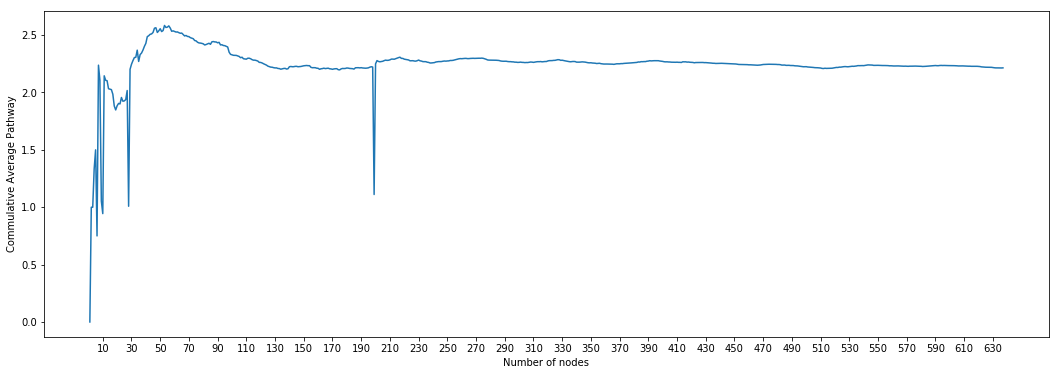

In [19]:
#SMALL WORLD PROPERTIES
def plot_cumm_APL(cumm_avg_pathway):
    y=cumm_avg_pathway
    x=list(range(1,638))

    plt.figure(figsize=(18, 6))
    plt.plot(x,y)
    plt.ylabel("Commulative Average Pathway")
    plt.xlabel("Number of nodes")
    plt.xticks(np.arange(min(x)+9, max(x), 20))

    plt.savefig("SW_plot.png")
    
    y=comm_avg_pathway
    x=np.log(list(range(1,638)))

    plt.figure(figsize=(18, 6))
    plt.plot(x,y)
    plt.ylabel("Commulative Average Pathway")
    plt.xlabel("Log Number of nodes")
    plt.xticks(np.arange(min(x), max(x)))

    plt.savefig("SW_LogPlot.png")

print("Cummulative average path length vs number of nodes for our network")
plot_cumm_APL(cumm_avg_pathway)

print("Cummulative average path length vs number of nodes for null model")
plot_cumm_APL(cumm_avg_pathway_null)
    

Small World = Small Diameter + Clustering 

Defined by two measures: 
– characteristic path length L 
– clustering coefficient C

C >> C_random, L aprox= L_random 

In the human brian:
– It's a small world for certain values, 0<Log(N)<4 (see reference)

Centrality measures

In [19]:
#CENTRALITY
ev_centrality = nx.eigenvector_centrality_numpy(G)
print("Eigenvector centrality", ev_centrality)

#for k,v in sorted(ev_centrality.items(), key=lambda p:p[1], reverse=True):
    #print(k,v)

bn_centrality = nx.betweenness_centrality(G)
print("Betweeness centrality", bn_centrality)

#weighted Degree
print("Weighted Degree:", weightedDegree)

Eigenvector centrality {0: 0.003039522826410444, 1: 0.0018603433010364297, 2: 0.019708765472981442, 3: 0.0224559617610217, 4: 0.0016048708644181358, 5: 0.027149233214774093, 6: 0.053693718977569985, 7: 0.08525427762222922, 8: 0.005016898741366804, 9: 0.0055437585156059305, 10: 0.018836927198819246, 11: 0.006844962918314067, 12: 0.020600703476850602, 13: 0.018243648819894515, 14: 0.004971821946616256, 15: 0.00967382815846928, 16: 0.0861474460028185, 17: 0.011433001962681388, 18: 0.04595620672542657, 19: 0.07797543131663728, 20: 0.05007558372512901, 21: 0.008238245608483291, 22: 0.0030003460985530547, 23: 0.0035093252478588625, 24: 0.002411374629612562, 25: 0.009042241565770812, 26: 0.002924917180712148, 27: 0.009189104314943363, 28: 0.004726515368580436, 29: 0.01630722788774822, 30: 0.006029910231489148, 31: 0.013498082425535005, 32: 0.005741323108943903, 33: 0.007377070560501219, 34: 0.005608713538135978, 35: 0.02122158492493459, 36: 0.02240444490809584, 37: 0.07341075694033744, 38: 0.

Betweeness centrality {0: 0.0010679709088381893, 1: 0.0007643194212274356, 2: 0.0009251182608225745, 3: 0.000731344353154541, 4: 0.001250244597506526, 5: 0.0024916961047958433, 6: 0.0010412327151938258, 7: 0.004704771052854631, 8: 0.0017601151320651382, 9: 0.0033844082514671277, 10: 0.0036471476708152422, 11: 0.0050952653194784835, 12: 0.0015335660692524337, 13: 0.003061221276946681, 14: 0.0025908183685500403, 15: 0.0018620139689022, 16: 0.00422111590638329, 17: 0.005031266507748306, 18: 0.002593110860454843, 19: 0.00211201007284138, 20: 0.0005459143981170759, 21: 0.0012852201292442927, 22: 0.003020281129832216, 23: 0.0026974953770785774, 24: 0.0016864747729162294, 25: 0.004428290787510182, 26: 0.0005108857513936195, 27: 0.0005960821696307883, 28: 0.0008962029248916711, 29: 0.0008694332746355801, 30: 0.00023360263771581125, 31: 0.0008873762774078129, 32: 0.0008644627943640734, 33: 0.00020386874659684214, 34: 0.00029923214991625126, 35: 0.0004493008244124218, 36: 0.0016005706972965468, 

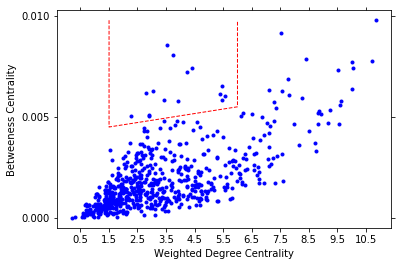

In [20]:
#x=list(ev_centrality.values())
y=list(bn_centrality.values())
x=list(weightedDegree)
#y=list(bn_centrality.values())

points = np.column_stack([x, y])
verts = np.array([[0.01, 0.01, 1.5, 1.5, ], [max(y)+0.005, 0.019, 0.030, max(y)+0.005]]).T
path = mpath.Path(verts)
points_inside = points[path.contains_points(points)]

plt.figure()
plt.autoscale(enable=True, axis='y', tight=False)
plt.autoscale(enable=True, axis='x', tight=False)
plt.xticks(np.arange(min(x)+0.3, max(x)+0.5, 1))
plt.yticks(np.arange(min(y), max(y)+0.005, 0.005))
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.ylabel("Betweeness Centrality")
#plt.xlabel("EigenVector Centrality")
plt.xlabel("Weighted Degree Centrality")
#plt.ylabel("Betweeness Centrality")


plt.plot(x, y, color='b', marker='o', linestyle="None", markersize=3)
#plt.savefig('dgVSbn.png')


plt.plot([1.5, 1.5, 6, 6, ], [max(y), 0.0045, 0.0055, max(y)], color='r', linewidth=1, linestyle='--')
plt.scatter(points_inside[:,0], points_inside[:,1], c='r', s=25)
plt.savefig('wdgVSbn.png')


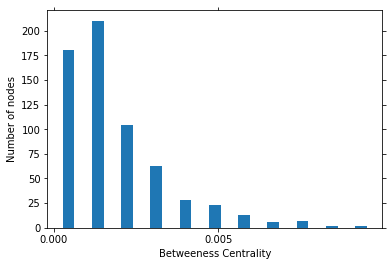

In [21]:
#Individual Histogram of Betweeness Centrality
x=list(bn_centrality.values())

plt.figure()
plt.hist(list(bn_centrality.values()), bins=11, rwidth=0.4)
plt.xlabel("Betweeness Centrality")
plt.ylabel("Number of nodes")
plt.xticks(np.arange(min(x), max(x), 0.005))

plt.savefig("bn_hist.png")